In [29]:
import os
import sys
import tarfile
import time
import urllib.request

In [30]:
source = 'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
target = 'aclImdb_v1.tar.gz'


def reporthook(count, block_size, total_size):
    global start_time
    if count == 0:
        start_time = time.time()
        return
    duration = time.time() - start_time
    progress_size = int(count * block_size)
    speed = progress_size / (1024.**2 * duration)
    percent = count * block_size * 100. / total_size

    sys.stdout.write("\r%d%% | %d MB | %.2f MB/s | %d sec elapsed" %
                    (percent, progress_size / (1024.**2), speed, duration))
    sys.stdout.flush()


if not os.path.isdir('aclImdb') and not os.path.isfile('aclImdb_v1.tar.gz'):
    urllib.request.urlretrieve(source, target, reporthook)

In [31]:
if not os.path.isdir('aclImdb'):

    with tarfile.open(target, 'r:gz') as tar:
        tar.extractall()

# 영화 리뷰 데이터셋을 더 간편한 형태로 전처리

In [32]:
!pip install pyprind

Defaulting to user installation because normal site-packages is not writeable


In [46]:
labels

{'pos': 1, 'neg': 0}

KeyError: ('pos', 'neg')

In [90]:
import pyprind
import pandas as pd
import os

# `basepath`를 압축 해제된 영화 리뷰 데이터셋이 있는
# 디렉토리로 바꾸세요

basepath = r'C:\ex\aclImdb'

labels = {'pos': 1, 'neg': 0}
pbar = pyprind.ProgBar(50000)
df = pd.DataFrame()
for s in ('test', 'train'):
    for l in ('pos', 'neg'):
        path = os.path.join(basepath, s, l)
        for file in sorted(os.listdir(path)):
            with open(os.path.join(path, file),
                      'r', encoding='utf-8') as infile:
                txt = infile.read()
            new_row = pd.DataFrame([[txt, labels[l]]],
                                   columns=['review', 'sentiment'])
            df = pd.concat([df, new_row], ignore_index=True)
            # 예를 들어, sentiment 열이 특정 값에 따라 변환해야 할 경우
            pbar.update()
df.columns = ['review', 'sentiment']

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:29


In [91]:
import numpy as np

np.random.seed(0)
df = df.reindex(np.random.permutation(df.index))

In [92]:
df.to_csv('movie_data.csv', index=False, encoding='utf-8')

In [93]:
import pandas as pd

df = pd.read_csv('movie_data.csv', encoding='utf-8')
df.head(3)

,review,sentiment
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1
1,OK... so... I really like Kris Kristofferson a...,0
2,"***SPOILER*** Do not read this, if you think a...",0


In [94]:
df['sentiment'].value_counts()

sentiment
1    25000
0    25000
Name: count, dtype: int64

In [95]:
df

,review,sentiment
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1
1,OK... so... I really like Kris Kristofferson a...,0
2,"***SPOILER*** Do not read this, if you think a...",0
3,hi for all the people who have seen this wonde...,1
4,"I recently bought the DVD, forgetting just how...",0
...,...,...
49995,"OK, lets start with the best. the building. al...",0
49996,The British 'heritage film' industry is out of...,0
49997,I don't even know where to begin on this one. ...,0
49998,Richard Tyler is a little boy who is scared of...,0


# BoW - 단어를 특성 벡터로 변환

In [101]:
# Bag of Words
# 단어들의 순서는 전혀 고려하지 않고
# 단어들의 출현 빈도(frequency)에만 집중하는 텍스트 데이터의 수치화 표현 방법

# 해당 문서 내에서 특정 단어가 N번 등장했다면
# 이 가방에는 그 특정 단어가 N개 있게됩니다
# 또한 가방을 흔들어서 단어를 섞었기 때문에
# 더 이상 단어의 순서는 중요하지 않습니다

In [96]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
# 문서에서 단어의 빈도수를 계산해서 문서 단어 행렬을 만들어줌

count = CountVectorizer()
docs = np.array([
        'The sun is shining',
        'The weather is sweet',
        'The sun is shining, the weather is sweet, and one and one is two'])
bag = count.fit_transform(docs)

In [97]:
print(count.vocabulary_)

{'the': 6, 'sun': 4, 'is': 1, 'shining': 3, 'weather': 8, 'sweet': 5, 'and': 0, 'one': 2, 'two': 7}


In [ ]:
# 왜 희소 행렬이 있는가

# 각 문서에 있는 고유한 단어는
# BoW 어휘 사전에 있는 모든 단어의 일부분에 지나지 않으므로
# 특성 벡터는 대부분이 0으로 채워짐

# 이 특성 벡터를 희소 sparse 라 한다

In [98]:
print(bag.toarray())
# 특성 벡터 출력

# 문서-단어 행렬을 넘파이 배열로 변환하는 메서드
# 희소 행렬을 밀집 배열로 변환

[[0 1 0 1 1 0 1 0 0]
 [0 1 0 0 0 1 1 0 1]
 [2 3 2 1 1 1 2 1 1]]


In [99]:
# TF-IDF(Term Frequency-Inverse Document Frequency)
# 단어의 빈도와 역 문서 빈도(문서의 빈도에 특정 식을 취함)를 사용하여
# DTM 내의 각 단어들마다 중요한 정도를 가중치로 주는 방법

tf-idf = 단어 빈도 * 역문서 빈도

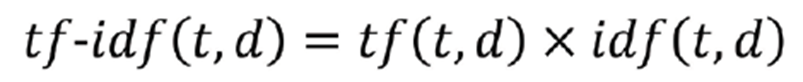

idf(t,d) = 역문서 빈도

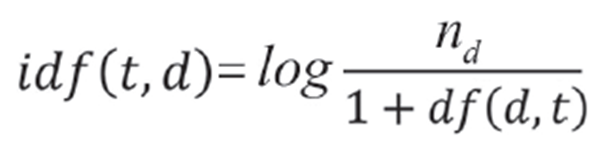

In [102]:
# 왜 log를 붙이는가

# 로그는 희귀 단어의 중요성을 높인다
# idf 란 특정 단어의 희귀성을 측정
# 문서에서 드물수록 idf 값은 올라간다

# 값의 범위를 압축
# 매우 자주 등장하는 단어와 그렇지 않은 단어의 차이를 줄인다
# 특정 단어에 민감해지는 것을 방지

In [100]:
# n 아래 첨자 d 전체 문서 개수
# df(d,t) 단어 t가 포함된 문서 d의 개수

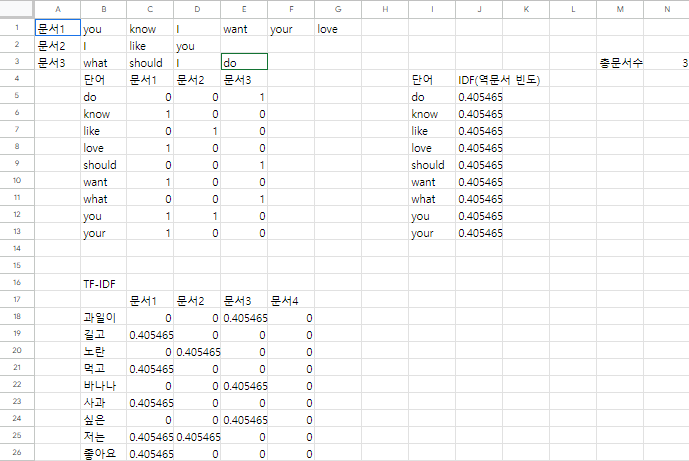